# Navigation

---

In this notebook, we start and interact with the environment to train an agent or watch him collect bananas.

### 1. Necessary imports and defining the constants

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [8]:
from collections import deque
import pickle

import numpy as np
import pandas as pd
import torch
from unityagents import UnityEnvironment
from tqdm import tqdm

from dqn_agent import Agent

%matplotlib inline 

# Use the GPU if one is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Next, we will define all the constants relevant to this notebook. This is the only cell you need to modify. The rest of the notebook should run without any modifications.
Change the `env_file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

The parameters `pers`, `duellings`, `suffs` and `legend_names` are lists with the same length if you want to train multiple different agents.

In [5]:
env_file_name = 'Banana_Windows_x86_64/Banana.exe'   # Path to the Unity environment.
n_episodes = 1000                                    # Number of episodes to train on
suffs = ['woper','wper','wper_duell']                # Suffix(es) to add to saved modelnames and scores according to the agent specifications you want to use
legend_names = ['Without PER',                       # Legend name(s) that will be displayed in the scoreplot according to suffs
                'With PER', 
                'With PER and duelling']               
pers = [False, True, True]                           # If True, will use prioritized experience replay (per). (according to suffs)
duellings = [False, False, True]                     # If True, will use the duelling network architecture. (according to suffs)
agent_to_watch = 1                                   # Index of agent you want to watch after training corresponding to lists defined aboce
n_episodes_to_watch = 2                              # Numbers of episodes to watch the trained agent

### 2. Setting up the environment

In this step we start the environment, save the `brain_name`, which we need to interact with the environment and save the size of the state- and action-space.

In [6]:
env = UnityEnvironment(file_name=env_file_name)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# dimension of the state-space 
state_size = len(env_info.vector_observations[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Train an agent

In the next code cells we define a training-method and anfter that initialize and train agents. The trained model-parameters will be saved every 250 episodes in `checkpoint_{model_suff}.pth`. It loops through all specified agent-parameters. If `per==True` it will prepopulate the memory with experiences from random actions before training.

Training will be done on the gpu if one is available.

If you just want to analyse already trained agent, you can skip this section.

In [5]:
def prepop_memory(agent, env):
    """ Prepoulates the memory with experiences 
    from random actions if training with prioritized experience replay.
    
    Params
    ======
        agent (Agent): instance of class Agent which memory should be filled.
        env (banana environment): environment to interact with.
    """
    
    print("Prepopulating the Memory...", end="")
    pretrain_length = agent.memory.tree.capacity 
    
    actions = np.random.choice(np.arange(agent.action_size), pretrain_length)
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]

    for i in tqdm(range(pretrain_length)):
               
        # Random action
        action = actions[i]
        
        # Take the action
        env_info = env.step(np.int32(action))[brain_name] 

        # Get next_state, reward and done
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished

        # Store the experience in the memory
        agent.memory.add(state, action, reward, next_state, done)
               
        # Reset env if done
        if done:
            env_info = env.reset(train_mode=True)[brain_name] # reset the environment
            state = env_info.vector_observations[0]
        else:
            state = next_state
    print("\rPrepopulating the Memory...finished\n", end="")
    return agent

def train_agent(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, model_suff=""):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        model_suff (string): suffix to append for storing the model parameters and the score
    """
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        score = 0
        while True:
            
            action = agent.act(state, eps)                      # Select an action using epsilon-greedy
            env_info = env.step(np.int32(action))[brain_name]   # send the action to the environment
            next_state = env_info.vector_observations[0]        # get the next state
            reward = env_info.rewards[0]                        # get the reward
            done = env_info.local_done[0]                       # see if episode has finished
            
            agent.step(state, action, reward, next_state, done) # Stores the experiernce and performs a 
                                                                # learning step, if the memory is large enough.
            state = next_state
            score += reward
           
            if done:
                break 
        
        scores_window.append(score)       # save most recent windowed score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\tLast Score: {:.2f}'.format(i_episode, np.mean(scores_window), scores[-1]), end="")
        if i_episode % 250 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), f"checkpoint_{model_suff}.pth")
    print("\n")
    torch.save(agent.qnetwork_local.state_dict(), f"checkpoint_{model_suff}.pth")
    return scores

In [6]:
# Make sure all agent-parameters are in list-form and have the same length
if type(pers)!=list: pers = [pers]
if type(duellings)!=list: duellings = [duellings]
if type(suffs)!=list: suffs = [suffs]
if type(legend_names)!=list: legend_names: [legend_names]
param_lengths = [len(pers), len(duellings), len(suffs), len(legend_names)]
        
assert max(param_lengths)==min(param_lengths), "Lengths of specified parameters are not equal!"
        
# Loop through all specified agents
for per, duelling, suff in zip(pers, duellings, suffs):
    # Print which agent is currently training
    print(f"Agent {suff} is now training...")
    
    # Initialize agent and - if necessary - prepopulate the memory
    agent = Agent(state_size=state_size, action_size=action_size, seed=0, per=per, duelling=duelling)
    if per: agent = prepop_memory(agent, env)
        
    # Train the agent and save the scores for later analysis
    scores = train_agent(n_episodes=n_episodes, model_suff=suff)
    pickle.dump(scores, open(f"Scores_{suff}.pkl", 'wb'))

Agent wper is now training...
Prepopulating the Memory...

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:28<00:00, 674.39it/s]


Prepopulating the Memory...finished
Episode 250	Average Score: 2.07
Episode 500	Average Score: 9.13
Episode 750	Average Score: 16.30
Episode 1000	Average Score: 16.86


Agent wper_duell is now training...
Prepopulating the Memory...

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:20<00:00, 711.39it/s]


Prepopulating the Memory...finished
Episode 250	Average Score: 0.64
Episode 500	Average Score: 6.37
Episode 750	Average Score: 15.61
Episode 1000	Average Score: 14.93




### 4. Whatch a trained agent collect bananas
Next we can watch the trained agent collect bananas for `n_episodes_to_watch` episodes. Therefore we load the model-parameters, reset the environment and loop through the specified number of episodes only using greedy actions. This can lead to states in wich the agent is stuck. Perhaps a small epsilon would fix this.

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, per=pers[agent_to_watch], duelling=duellings[agent_to_watch])
agent.qnetwork_local.load_state_dict(torch.load(f"checkpoint_{suffs[agent_to_watch]}.pth", map_location=device))
env_info = env.reset(train_mode=True)[brain_name] # reset the environment

scores = []                            # list containing scores from each episode
for i_episode in range(1, n_episodes_to_watch+1):    # Loop through five episodes
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]
    score = 0
    while True:
        action = agent.act(state, 0)                        # Select an action by greedily choosing the actions with the highest Q-Values
        env_info = env.step(np.int32(action))[brain_name]   # send the action to the environment
        state = env_info.vector_observations[0]             # get the next state
        reward = env_info.rewards[0]                        # get the reward
        done = env_info.local_done[0]                       # see if episode has finished

        score += reward                                     # update the score

        if done:
            break 
    scores.append(score)              # save most recent score
print(f"Avg. score: {np.mean(scores):.3}")

Avg. score: 12.5


### 5. Plot the learning-curve of all trained agents
In the last section we want to take a look at the learning curves of all trained agents. For orientation the goal-score (13) is also plottet.

In [10]:
def plot_scores(suffs, legend_names=None):
    """ Plots the scores from different runs. 

    For clarity only a maximum of 6 runs will be plotted. 
    
    Params
    ======
        suffs (list of strings): defined suffixes of the trained agents
        legend_names (list of strings): If legend_names is provided, the lines will be named accordingly.
    """
    
    colors = ['b','r','g','c','m','y']
    
    # Make sure the suffs- and legend_names-lists have the same length. If legend_names is not
    # provided, suffs will be used instead.
    if legend_names is not None:
        assert(len(suffs)==len(legend_names)), "Size of suffix-list doesn't match Size of names-list"
    else:
        legend_names = suffs
    
    # Initialize the scores DataFrame
    scores_df = pd.DataFrame()
    
    # Loop through all agents to compare
    for i, name in enumerate(legend_names):
        # Load the respective score and calculate the 100-moving average
        scores = pickle.load(open(f"Scores_{suffs[i]}.pkl", 'rb'))
        scores_df[name] = scores
        scores_df[name+"_100MA"] = scores_df[name].rolling(window=100).mean()
    
    # Add a column for the Goal-Line
    scores_df['Solved threshold'] = np.ones(len(scores_df))*13
    
    # Plot the lines
    ax = scores_df[legend_names].plot(color=colors[:len(legend_names)], alpha=.4)
    scores_df[[name+'_100MA' for name in legend_names]].plot(color=colors[:len(legend_names)], ax=ax)
    scores_df[['Solved threshold']].plot(style='k--', ax=ax)
    
    # Set the axis-labels
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Score')

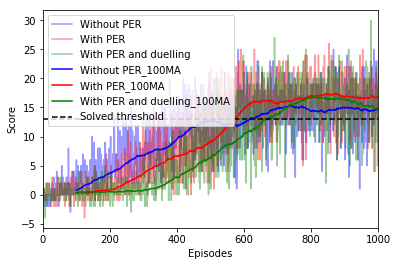

In [11]:
plot_scores(suffs, legend_names)

### 6. Close the environment

In [12]:
env.close()